# Approximating functions with deep ReLU networks
*Practical session during the [Oberwolfach Seminar on Mathematics of Deep Learning](https://www.mfo.de/occasion/1842b), October, 2018.*
The content is mostly based on [D. Yarotsky, 2017](https://www.sciencedirect.com/science/article/pii/S0893608017301545).

## Part I: Basic building blocks

In this part we will explore how several rather **simple functions** can be approximated using ReLU networks. These can then later be used to build more complex function approximations. 

The simple functions include:
* a **hat** function
* **sawtooth** functions
* the **square** function
* **multiplication**
* **partition of unity** by piecewise linear bump functions


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ipywidgets import interactive_output, HBox, VBox, FloatSlider, IntSlider
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

### ReLUs & hat functions

Let us start by recalling that the **ReLU** activation function is simply a continuous piecewise linear function with one breakpoint at the origin, defined as

$$ \mathrm{relu}(x) = \max\{0, x\}. $$

The ReLU function can be used to build other continuous piecewise linear functions with more than one breakpoint, by taking **linear combinations** of several shifted ReLUs. These operations can be performed by shallow neural networks.

Below, we show a linear combination of three shifted ReLU functions

$$ w_1 \mathrm{relu}(x-b_1) + w_2 \mathrm{relu}(x-b_2) + w_3 \mathrm{relu}(x-b_3).$$

Play around with the sliders below, to see how the **weights** $w$ and **shifts (biases)** $b$ affect the result. Note, that the setting 

$$w_1=w_3=2,\\ w_2=-4,\\ b_1=0,\\ b_2=\frac{1}{2},\\ b_3=1,$$

yield a hat function.

In [2]:
# numpy vectorized ReLU
def relu(x):
    return np.maximum(0.0, x)

In [21]:
# setup domain and plotting grid points
domain = [-2.0, 2.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)

# create sliders for interactive plot
w1_slider = FloatSlider(2.0, min=-4.0, max=4.0, description='$w_1$', style={'handle_color':'red'})
w2_slider = FloatSlider(-4.0, min=-4.0, max=4.0, description='$w_2$', style={'handle_color':'green'})
w3_slider = FloatSlider(2.0, min=-4.0, max=4.0, description='$w_3$', style={'handle_color':'blue'})
b1_slider = FloatSlider(0.0, min=-2.0, max=2.0, description='$b_1$', style={'handle_color':'red'})
b2_slider = FloatSlider(0.5, min=-2.0, max=2.0, description='$b_2$', style={'handle_color':'green'})
b3_slider = FloatSlider(1.0, min=-2.0, max=2.0, description='$b_3$', style={'handle_color':'blue'})

# prepare plots of different ReLU functions
def plot_relus(w1, b1, w2, b2, w3, b3):
    ys = relu(xs)
    ys1 = relu(xs-b1)
    ys2 = relu(xs-b2)
    ys3 = relu(xs-b3)
    plt.plot(
        xs, ys, 'k-',
        xs, ys1, 'r--',
        xs, ys2, 'g--',
        xs, ys3, 'b--',
        xs, w1*ys1+w2*ys2+w3*ys3, 'm-',
        linewidth=4,
    )
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(('$\mathrm{relu}(x)$',
                '$\mathrm{relu}(x-b_1)$',
                '$\mathrm{relu}(x-b_2)$',
                '$\mathrm{relu}(x-b_3)$',
                '$\sum_i w_i \mathrm{relu}(x-b_i)$'), loc='best')
    plt.ylim(-1, 3.0)
    plt.title('linear combination of shifted ReLUs')

# show interactive plot
plot = interactive_output(plot_relus, {
    'w1':w1_slider, 'w2':w2_slider, 'w3':w3_slider, 'b1':b1_slider, 'b2':b2_slider, 'b3':b3_slider
})
HBox([plot, VBox([w1_slider, w2_slider, w3_slider, b1_slider, b2_slider, b3_slider])])

### Sawtooth functions

Let us denote this **hat function** by $g$, that is

$$ g(x) = 2\,\mathrm{relu}\left(x\right) - 4\,\mathrm{relu}\left(x-\frac{1}{2}\right) + 2\,\mathrm{relu}\left(x-1\right). $$

We can then, by repeatedly composing $g$ with itself, generate so called **sawtooth functions**

$$ g_s(x) = \underbrace{\left(g\circ g\circ \dots \circ g\right)}_{s\text{ times }}(x),\quad s=1, 2, \dots .$$

The function $g_s$ has $2^{s-1}$ equidistant "teeth" in the interval $[0, 1]$. In order to efficiently represent all the composition functions $g_s$ simultaneously by ReLU networks it is convenient to allow so called **skip connections** in the network architectures. This means, that every layer in the network can have connection to **all** following layers, not only the next layer.

In [4]:
# numpy vectorized hat and sawtooth functions
def g(x):
    return 2*relu(x) - 4*relu(x-0.5) + 2*relu(x-1)

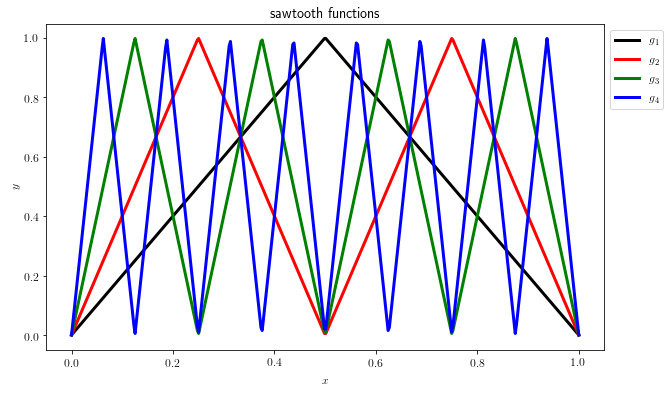

In [20]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 400
xs = np.linspace(domain[0], domain[1], resolution)

# plot sawtooth functions
ys1 = g(xs)
ys2 = g(ys1)
ys3 = g(ys2)
ys4 = g(ys3)
plt.plot(
    xs, ys1, 'k-',
    xs, ys2, 'r-',
    xs, ys3, 'g-',
    xs, ys4, 'b-',
    linewidth=3,
)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('sawtooth functions')
plt.legend(('$g_1$', '$g_2$', '$g_3$', '$g_4$'), loc='upper left', bbox_to_anchor=(1.0, 1.0));

### The square function

We will now find out for what these sawtooth functions $g_s$ can be useful. For this, consider the **square function**

$$ f(x) = x^2. $$

The square function will come in handy for approximating the multiplication function $\times\colon [0,1]^2 \rightarrow [0,1]\colon (x,y) \mapsto xy$ later.

We have already discussed, that piecewise linear functions can be build from ReLU networks, so it seems natural to try to approximate the square function $f$ by piecewise linear functions. Denote by $f_m$ for $m=1, 2, \dots$ the **piecewise linear interpolation** of $f$ with $2^m + 1$ equidistant breakpoints in the interval $[0,1]$. That is 

$$ f_m\left(\frac{k}{2^m}\right) = \left(\frac{k}{2^m}\right)^2,\quad k=0,\dots, 2^m,$$

and $f_m$ is affine linear in between the breakpoints. Note that the difference between two consecutive interpolations $f_m$ and $f_{m-1}$ is a scaled version of the sawtooth function $g_m$. In fact,

$$f_m(x) = x - \sum_{s=1}^{m} \frac{g_s(x)}{2^{2s}}.$$

As each of the $g_s$ can be represented by a ReLU network and we only take linear combinations of $g_s$ and the identity function, we see that $f_m$ can be represented by a ReLU network. Finally, as $f_m$ converges uniformly to $f$ on $[0,1]$, we can approximate $f$ arbitrarily well by a ReLU network. 

The **size** of such a network (number of neurons, number of connections, number of weights) which approximates $f$ up to $\epsilon>0$ is bounded by 

$$ \mathcal{O}\left(\ln\frac{1}{\epsilon}\right).$$

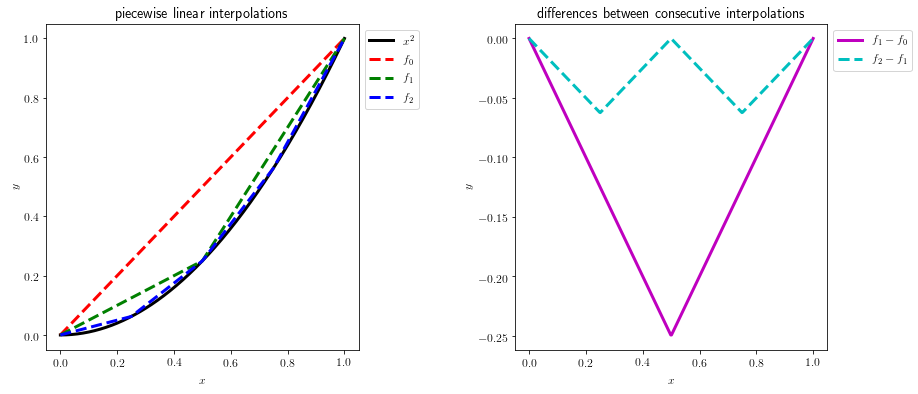

In [18]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 400
xs = np.linspace(domain[0], domain[1], resolution)
xs0 = np.linspace(domain[0], domain[1], 2)
xs1 = np.linspace(domain[0], domain[1], 3)
xs2 = np.linspace(domain[0], domain[1], 5)

# plot square functions and approximations
ys = np.square(xs)
ys0 = np.square(xs0)
ys1 = np.square(xs1)
ys2 = np.square(xs2)
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(
    xs, ys, 'k-',
    xs0, ys0, 'r--',
    xs1, ys1, 'g--',
    xs2, ys2, 'b--',
    linewidth=3,
)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(('$x^2$', '$f_0$', '$f_1$', '$f_2$'), loc='upper left', bbox_to_anchor=(1.0, 1.0));
plt.title('piecewise linear interpolations')

# plot approximation differences
f0 = interp1d(xs0,ys0)
f1 = interp1d(xs1,ys1)
f2 = interp1d(xs2,ys2)
plt.subplot(1,2,2)
plt.plot(
    xs, f1(xs) - f0(xs), 'm-',
    xs, f2(xs) - f1(xs), 'c--',
    linewidth=3,
)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(('$f_1-f_0$', '$f_2-f_1$'), loc='upper left', bbox_to_anchor=(1.0, 1.0));
plt.title('differences between consecutive interpolations')

plt.subplots_adjust(wspace=0.5)

In [17]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 200
xs = np.linspace(domain[0], domain[1], resolution)

# numpy vectorized square approximation function
def asquare(x, m):
    ysa = np.copy(x)
    gsi = np.copy(x)
    for i in range(1,m+1):
        gsi = g(gsi)
        ysa -= gsi/(2**(2*i))
    return ysa

# create slider for interactive plot
m_slider = IntSlider(1, min=0, max=5, description='$m$', style={'handle_color':'green'})

# prepare interactive plot
def plot_asquare(m=m_slider):
    ys = np.square(xs)
    ysa = asquare(xs, m)
    plt.plot(
        xs, ys, 'k-',
        xs, ysa, 'g-',
        xs, ysa - ys, 'r--',
        linewidth=3
    )
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(('$x^2$', '$f_m(x), m={}$'.format(m), '$f_m(x)-x^2$'), loc='best')
    plt.title('approximating the square function')

# show interactive plot
plot = interactive_output(plot_asquare, {'m': m_slider})    
HBox([plot, m_slider])

### Multiplication

Finally, let us consider the **multiplication function** already mentioned before. Using the identity

$$ xy = \frac{1}{2}\left((x+y)^2 -x^2 -y^2\right) $$

we can now approximate multiplication using linear combinations of $f$ evaluated at linear combinations of $x$ and $y$. We already know how to approximate the square function by ReLU networks, thus altogether we can approximate also multiplication by ReLU networks. 

*Remark 1: This only increases the networks size by a constant compared to the approximation of $f$ by a network.*

*Remark 2: So far we have restricted our attention to the domain $[0,1]$ or $[0,1]^2$. However, it is not hard to see that by appropriate rescaling this can be extended to arbitrary bounded domains $[-M, M]^2$, in which case the network size increases to* 

$$ \mathcal{O}\left(\ln\frac{1}{\epsilon} + \ln M\right).$$

In [14]:
# setup domain and plotting grid points
domain = [0.0, 1.0, 0.0, 1.0]
resolution = 100
xs = np.linspace(domain[0], domain[1], resolution)
ys = np.linspace(domain[2], domain[3], resolution)
xgrid, ygrid = np.meshgrid(xs, ys)

# create slider for interactive plot
m_slider = IntSlider(1, min=0, max=5, description='$m$')

# prepare interactive plot of multiplication function
def plot_mult(m=m_slider):

    # plot multiplication function
    zs = xgrid*ygrid
    plt.figure(figsize=(14, 6))
    plt.subplot(1,3,1)
    plt.imshow(
        zs,
        extent=domain,
        origin='lower',
        vmin=0.0,
        vmax=1.0,
    )
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('multiplication $xy$')

    # plot multiplication approximation 
    zsa = (asquare(np.abs(xgrid+ygrid)/2, m) - asquare(np.abs(xgrid)/2, m) - asquare(np.abs(ygrid)/2, m))*2 
    plt.subplot(1,3,2)
    plt.imshow(
        zsa, 
        extent=domain,
        origin='lower',
        vmin=0.0,
        vmax=1.0,
    )
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('approximation')

    # plot difference
    plt.subplot(1,3,3)
    plt.imshow(
        np.abs(zsa-zs), 
        extent=domain,
        origin='lower',
        cmap=plt.get_cmap('Greys_r'),
        vmin=0.0,
        vmax=0.2,
    )
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('error')

    plt.subplots_adjust(wspace=0.5)
    
# show interactive plot
plot = interactive_output(plot_mult, {'m': m_slider})
HBox([plot, m_slider])

### Partition of unity
We now have the basic building blocks ready to use for approximating more complicated functions. The main idea is to use the multiplication operation to build **multivariate polynomials**, and then in turn use these polynomials to build **local Taylor expansions** of the target functions that we want to approximate. 

In order to make this work we need a method to localize polynomials. It is not hard to see how piecewise-linear **bump functions** can be constructed from ReLUs in a way similar to the construction of the hat function seen before. 

$$ \mathrm{bump}(x) = \mathrm{relu}(x+2) - \mathrm{relu}(x+1) - \mathrm{relu}(x-1) + \mathrm{relu}(x-2) $$

These bump functions together with multiplication operation can be used to build multivariate localized bumps that form a **partition of unity** on $[0,1]$.

$$ \mathrm{bump}_{k,N}\left(3N\left(x-\frac{k}{N}\right)\right),\quad k=0,\dots,N,\quad N\in\mathbb{N} $$

This is illustrated for the one-dimensional case below.

A general function expansion can then be written in the form

$$ \sum_k \sum_n a_{k,n} \mathrm{bump}_{k,N}(x)\left(x-\frac{k}{N}\right)^n $$

for some coefficients $a_{k,n}$.

In [16]:
# setup domain and plotting grid points
domain = [0.0, 1.0]
resolution = 400
xs = np.linspace(domain[0], domain[1], resolution)

# create slider for interactive plot
N_slider = IntSlider(3, min=1, max=8, description='$N$')

# prepare interactive plot of multiplication function
bump = lambda x: relu(x+2) - relu(x+1) - relu(x-1) + relu(x-2)
def plot_bumps(N=N_slider):
    for k in range(N+1):
        plt.plot(xs, bump(3*N*(xs-k/N)))
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('partition of unity')

# show interactive plot
plot = interactive_output(plot_bumps, {'N': N_slider})
HBox([plot, N_slider])